In [ ]:
import pandas as pd, numpy as np, re, unicodedata

# 1) Load (replace with your CSV path)
df = pd.read_csv("communications.csv")  # columns: Date, Release Date, Type, Text

# 2) Dates & sort
for c in ["Date","Release Date"]:
    df[c] = pd.to_datetime(df[c], errors="coerce").dt.date
df = df.dropna(subset=["Text","Date","Release Date"]).sort_values(["Release Date","Type"]).reset_index(drop=True)

# 3) Clean text (unicode normalise, collapse whitespace)
def clean_text(s):
    s = unicodedata.normalize("NFKC", str(s))
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["Text"] = df["Text"].map(clean_text)

# 4) Keep 2000→now
df = df[df["Date"] >= pd.to_datetime("2000-01-01").date()].copy()

# 5) Add a stable id and prev-doc per Type (Statement/Minute)
df["doc_id"] = np.arange(len(df))
df = df.sort_values(["Type","Release Date"]).reset_index(drop=True)
df["prev_doc_id"] = df.groupby("Type")["doc_id"].shift(1)
df["prev_date"]   = df.groupby("Type")["Release Date"].shift(1)

# Optional sanity
print(df["Type"].value_counts(), df[["Date","Release Date"]].min(), df[["Date","Release Date"]].max(), sep="\n")

Type
Statement    219
Minute       207
Name: count, dtype: int64
Date            2000-02-02
Release Date    2000-02-02
dtype: object
Date            2025-10-29
Release Date    2025-10-29
dtype: object


In [ ]:
import re
import nltk, numpy as np, pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer, util

# Sentence splitter
nltk.download("punkt")
nltk.download('punkt_tab')
# --- FinBERT pipeline ---
fb_tok = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
fb_mod = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
finbert = pipeline("sentiment-analysis", model=fb_mod, tokenizer=fb_tok)

def split_by_tokens(text, tokenizer, max_tokens=500):
    """Split text into chunks where tokenizer.tokenize(chunk) ≤ max_tokens.
       Falls back to word-level splitting when a single sentence is too long."""
    sents = nltk.sent_tokenize(text)
    chunks, cur = [], ""

    def tok_len(s):  # WordPiece token count (no special tokens)
        return len(tokenizer.tokenize(s))

    for s in sents:
        cand = (cur + " " + s).strip() if cur else s
        if tok_len(cand) <= max_tokens:
            cur = cand
        else:
            if cur:
                chunks.append(cur)
            # If the single sentence itself is too long, hard-split by words
            if tok_len(s) > max_tokens:
                words, buf = s.split(), []
                for w in words:
                    trial = (" ".join(buf + [w])).strip()
                    if tok_len(trial) <= max_tokens:
                        buf.append(w)
                    else:
                        if buf:
                            chunks.append(" ".join(buf))
                        buf = [w]
                if buf:
                    cur = " ".join(buf)
                else:
                    cur = ""
            else:
                cur = s
    if cur:
        chunks.append(cur)
    return chunks

def finbert_tone(text, max_tokens=500):
    chunks = split_by_tokens(text, fb_tok, max_tokens=max_tokens)
    if not chunks:
        return 0.0, 0.0, 0.0
    # Call-time truncation/padding (belt & braces); with 500 tokens + [CLS]/[SEP] we stay < 512
    out = finbert(chunks, truncation=True, padding=True, max_length=512, batch_size=16)
    pos = sum(o["label"] == "Positive" for o in out)
    neg = sum(o["label"] == "Negative" for o in out)
    n   = max(1, len(out))
    score = (pos - neg) / n
    return float(score), float(pos/n), float(neg/n)

# --- Hawkish/dovish cue counts ---
hawkish = r"\b(inflation remains elevated|tight labour|labour market tight|upward pressure|rate increases|further firming|restrictive|strong demand|above target)\b"
dovish  = r"\b(moderating|softening|easing|below target|downward pressure|rate cuts|less restrictive|weaker demand)\b"
def cue_counts(text):
    H = len(re.findall(hawkish, text, flags=re.I))
    D = len(re.findall(dovish , text, flags=re.I))
    return H, D, (H - D)

# --- Embeddings + semantic delta ---
sent_mod = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
def doc_embed(text):
    return sent_mod.encode(text, normalize_embeddings=True)

# === Feature computation ===
rows = []
for _, r in df.iterrows():  # df must have ['Text','doc_id','prev_doc_id','Type','Date','Release Date']
    t = r["Text"]
    fb_score, fb_pos, fb_neg = finbert_tone(t, max_tokens=500)
    H, D, HD = cue_counts(t)
    emb = doc_embed(t)

    prev_cos = np.nan
    if pd.notna(r["prev_doc_id"]):
        t_prev = df.loc[df["doc_id"] == r["prev_doc_id"], "Text"]
        if not t_prev.empty:
            emb_prev = doc_embed(t_prev.values[0])
            prev_cos = util.cos_sim(emb, emb_prev).item()  # scalar

    rows.append({
        "doc_id": r["doc_id"],
        "Type": r["Type"],
        "Date": r["Date"],
        "Release Date": r["Release Date"],
        "finbert_score": fb_score,
        "finbert_pos": fb_pos,
        "finbert_neg": fb_neg,
        "hawk_cnt": H,
        "dove_cnt": D,
        "hawk_minus_dove": HD,
        "cos_prev": prev_cos,
        "delta_semantic": (1.0 - prev_cos) if pd.notna(prev_cos) else np.nan,
    })

X_text = pd.DataFrame(rows)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
Device set to use cuda:0


In [ ]:
X_text.tail(100)

,doc_id,Type,Date,Release Date,finbert_score,finbert_pos,finbert_neg,hawk_cnt,dove_cnt,hawk_minus_dove,cos_prev,delta_semantic
326,231,Statement,2013-10-30,2013-10-30,0.500000,0.500000,0.000000,0,1,-1,0.965794,0.034206
327,233,Statement,2013-12-18,2013-12-18,0.333333,0.333333,0.000000,0,1,-1,0.970377,0.029623
328,235,Statement,2014-01-29,2014-01-29,0.333333,0.333333,0.000000,0,1,-1,0.993198,0.006802
329,237,Statement,2014-03-19,2014-03-19,0.000000,0.333333,0.333333,0,1,-1,0.949799,0.050201
330,239,Statement,2014-04-30,2014-04-30,0.500000,0.500000,0.000000,0,1,-1,0.986341,0.013659
...,...,...,...,...,...,...,...,...,...,...,...,...
421,417,Statement,2025-05-07,2025-05-07,0.000000,0.000000,0.000000,0,0,0,0.915453,0.084547
422,419,Statement,2025-06-18,2025-06-18,0.000000,0.000000,0.000000,0,0,0,0.982181,0.017819
423,421,Statement,2025-07-30,2025-07-30,0.000000,0.000000,0.000000,0,0,0,0.996951,0.003049
424,423,Statement,2025-09-17,2025-09-17,0.000000,0.000000,0.000000,0,0,0,0.971443,0.028557


In [ ]:

import pandas as pd
from pandas_datareader import data as web

# 1) Figure out the date range we need, based on your FOMC documents
X_text["Release Date"] = pd.to_datetime(X_text["Release Date"])
start = X_text["Release Date"].min() - pd.Timedelta(days=30)
end   = X_text["Release Date"].max() + pd.Timedelta(days=30)

# 2) Download from FRED
series = ["DGS2", "DGS5", "DGS10"]  # 2y, 5y, 10y
rates = web.DataReader(series, "fred", start, end)  # columns: DGS2, DGS5, DGS10

# 3) Clean: forward-fill missing (weekends/holidays → carry last obs)
rates = rates.ffill()

rates.head(100)

,DGS2,DGS5,DGS10
DATE,,,
2000-01-03,6.38,6.50,6.58
2000-01-04,6.30,6.40,6.49
2000-01-05,6.38,6.51,6.62
2000-01-06,6.35,6.46,6.57
2000-01-07,6.31,6.42,6.52
...,...,...,...
2000-05-15,6.88,6.73,6.47
2000-05-16,6.89,6.72,6.43
2000-05-17,6.90,6.74,6.48


In [ ]:
rates.tail(100)

,DGS2,DGS5,DGS10
DATE,,,
2025-06-26,3.70,3.79,4.26
2025-06-27,3.73,3.83,4.29
2025-06-30,3.72,3.79,4.24
2025-07-01,3.78,3.84,4.26
2025-07-02,3.78,3.87,4.30
...,...,...,...
2025-11-06,3.57,3.69,4.11
2025-11-07,3.55,3.67,4.11
2025-11-10,3.58,3.72,4.13


In [ ]:
from pandas.tseries.offsets import BDay

# Work on statements first (cleanest link to "rates market reaction")
X = X_text[X_text["Type"] == "Statement"].copy()
X["Release Date"] = pd.to_datetime(X["Release Date"])

# Previous and next business days
X["t"]  = X["Release Date"]
X["t-1"] = X["t"] - BDay(1)
X["t+1"] = X["t"] + BDay(1)

# Convenience aliases
r2  = rates["DGS2"]
r5  = rates["DGS5"]
r10 = rates["DGS10"]

# Map dates → yields
X["y2_t"]   = X["t"].map(r2)
X["y2_tm1"] = X["t-1"].map(r2)
X["y2_tp1"] = X["t+1"].map(r2)

X["y5_t"]   = X["t"].map(r5)
X["y5_tm1"] = X["t-1"].map(r5)
X["y5_tp1"] = X["t+1"].map(r5)

X["y10_t"]   = X["t"].map(r10)
X["y10_tm1"] = X["t-1"].map(r10)
X["y10_tp1"] = X["t+1"].map(r10)

# 1-day reaction (t vs t-1), in basis points
for mat in ["2", "5", "10"]:
    X[f"dy{mat}_1d_bp"]   = 100 * (X[f"y{mat}_t"]   - X[f"y{mat}_tm1"])
    X[f"dy{mat}_2d_bp"]   = 100 * (X[f"y{mat}_tp1"] - X[f"y{mat}_tm1"])

# Keep only what we need going forward
cols_keep = [
    "doc_id", "Type", "Date", "Release Date",
    "finbert_score", "finbert_pos", "finbert_neg",
    "hawk_cnt", "dove_cnt", "hawk_minus_dove",
    "cos_prev", "delta_semantic",
    "dy2_1d_bp", "dy5_1d_bp", "dy10_1d_bp",
    "dy2_2d_bp", "dy5_2d_bp", "dy10_2d_bp",
]
X_merged = X[cols_keep].dropna(subset=["dy2_1d_bp", "dy5_1d_bp", "dy10_1d_bp"])

In [ ]:
X_merged.head()
X_merged.to_csv("X_merged.csv", index=False)

In [ ]:
row = X_text.iloc[-1]  # last statement
print(row["Date"], row["Release Date"])
print(df.loc[df["doc_id"] == row["doc_id"], "Text"].values[0][:800])

# Direct check:
t = df.loc[df["doc_id"] == row["doc_id"], "Text"].values[0]
chunks = split_by_tokens(t, fb_tok, max_tokens=500)
finbert(chunks[:3], truncation=True, padding=True, max_length=512)  # inspect labels

2025-10-29 2025-10-29 00:00:00
Available indicators suggest that economic activity has been expanding at a moderate pace. Job gains have slowed this year, and the unemployment rate has edged up but remained low through August; more recent indicators are consistent with these developments. Inflation has moved up since earlier in the year and remains somewhat elevated. The Committee seeks to achieve maximum employment and inflation at the rate of 2 percent over the longer run. Uncertainty about the economic outlook remains elevated. The Committee is attentive to the risks to both sides of its dual mandate and judges that downside risks to employment rose in recent months. In support of its goals and in light of the shift in the balance of risks, the Committee decided to lower the target range for the federal funds rate by


[{'label': 'Neutral', 'score': 0.9997255206108093}]

In [ ]:
!pip install --upgrade openai

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "XXX"

In [ ]:
import json, time, math, random
from openai import OpenAI

client = OpenAI()  # uses OPENAI_API_KEY from env

SYSTEM_PROMPT = """You are an expert fixed-income macro trader.
You rate the hawkishness of FOMC statements and minutes on a discrete scale:

-2 = strongly dovish (clear signal of easing or cuts soon, strong focus on downside risks)
-1 = mildly dovish (tilt towards growth risks or easing, but not decisive)
 0 = neutral / balanced (risks roughly balanced, no clear bias)
+1 = mildly hawkish (tilt towards inflation risks or further tightening, but not decisive)
+2 = strongly hawkish (clear tightening bias, strong emphasis on inflation and need to keep policy restrictive)

Higher scores imply higher expected future short-term interest rates and higher 2–5 year Treasury yields.

Return ONLY a JSON object of the form:
{"score": -2| -1 | 0 | 1 | 2, "short_reason": "<at most 25 words>"}
Do not include commentary, explanation, or any other text."""

In [ ]:
import os
import json
import time
import random
import pandas as pd
from openai import OpenAI

# ---------- OpenAI client ----------
# assumes OPENAI_API_KEY is set in your environment
client = OpenAI()

# ---------- Prompt / rubric ----------
SYSTEM_PROMPT = """
You are an expert fixed-income macro trader.
You rate the hawkishness of FOMC communications (statements or minutes) on a discrete scale:

-2 = strongly dovish (clear signal of easing or cuts soon, strong focus on downside risks)
-1 = mildly dovish (tilt towards growth risks or easing, but not decisive)
 0 = neutral / balanced (risks roughly balanced, no clear bias)
+1 = mildly hawkish (tilt towards inflation risks or further tightening, but not decisive)
+2 = strongly hawkish (clear tightening bias, strong emphasis on inflation and need to keep policy restrictive)

Higher scores imply higher expected future short-term interest rates and higher 2–5 year Treasury yields.

Return ONLY a JSON object of the form:
{"score": -2| -1 | 0 | 1 | 2, "short_reason": "<at most 25 words>"}
Do not include commentary, explanation, or any other text.
""".strip()


# ---------- Helper to build user prompt ----------
def build_user_prompt(text, doc_type="communication", max_chars=6000):
    """
    Prepare the user message shown to the model.
    doc_type is just a label in the text ("statement", "minutes", "communication"...).
    """
    snippet = text[:max_chars]
    return f"""Rate the hawkishness of the following FOMC {doc_type}.

TEXT:
\"\"\"{snippet}\"\"\""""


# ---------- Call GPT and parse JSON ----------
def call_gpt_hawk_score(
    text,
    doc_type="communication",
    model="gpt-4.1",
    max_retries=5,
    sleep_base=0.5,
):
    """
    Returns (score:int, short_reason:str).
    If anything fails after retries, returns (0, "parse_error").
    """
    user_prompt = build_user_prompt(text, doc_type=doc_type)

    for attempt in range(max_retries):
        try:
            resp = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": SYSTEM_PROMPT},
                    {"role": "user",   "content": user_prompt},
                ],
                temperature=0.0,
                max_tokens=128,
            )
            raw = resp.choices[0].message.content.strip()

            # try to locate JSON in case model wraps it accidentally
            start = raw.find("{")
            end   = raw.rfind("}")
            if start != -1 and end != -1:
                raw = raw[start:end+1]

            obj = json.loads(raw)
            score = int(obj["score"])
            reason = str(obj.get("short_reason", "")).strip()

            if score not in [-2, -1, 0, 1, 2]:
                raise ValueError("score out of range")

            return score, reason

        except Exception:
            # exponential backoff on failure
            wait = sleep_base * (2 ** attempt) + random.random() * 0.1
            time.sleep(wait)

    # if all retries fail
    return 0, "parse_error"


# ---------- Caching helpers ----------
CACHE_PATH = "gpt_hawk_scores.csv"

def load_cache(path=CACHE_PATH):
    if os.path.exists(path):
        return pd.read_csv(path)
    return pd.DataFrame(columns=["doc_id", "gpt_hawk_score", "gpt_reason"])


def save_cache(df_cache, path=CACHE_PATH):
    df_cache.to_csv(path, index=False)


# ---------- Main scoring loop ----------
# df must at least have: ["doc_id", "Text"]
cache = load_cache()
scored_ids = set(cache["doc_id"].tolist())

# score ALL docs not already in cache (statements + minutes + whatever)
to_score = df[~df["doc_id"].isin(scored_ids)].copy()

print(f"Total docs to score now: {len(to_score)}")

new_rows = []
processed = 0
total = len(to_score)

for _, r in to_score.iterrows():
    doc_id = r["doc_id"]
    text   = r["Text"]

    score, reason = call_gpt_hawk_score(text, doc_type="communication", model="gpt-4.1")
    new_rows.append({
        "doc_id": doc_id,
        "gpt_hawk_score": score,
        "gpt_reason": reason,
    })

    processed += 1
    if processed % 10 == 0:
        print(f"Scored {processed}/{total} documents so far...")

    # flush to cache every 10 new rows
    if len(new_rows) % 10 == 0:
        tmp = pd.DataFrame(new_rows)
        cache = (
            pd.concat([cache, tmp], ignore_index=True)
              .drop_duplicates("doc_id")
        )
        save_cache(cache)
        new_rows = []

# flush remaining
if new_rows:
    tmp = pd.DataFrame(new_rows)
    cache = (
        pd.concat([cache, tmp], ignore_index=True)
          .drop_duplicates("doc_id")
    )
    save_cache(cache)

print("Scoring finished. Cache size:", len(cache))

Total docs to score now: 197
Scored 10/197 documents so far...
Scored 20/197 documents so far...
Scored 30/197 documents so far...
Scored 40/197 documents so far...
Scored 50/197 documents so far...
Scored 60/197 documents so far...
Scored 70/197 documents so far...
Scored 80/197 documents so far...
Scored 90/197 documents so far...
Scored 100/197 documents so far...
Scored 110/197 documents so far...
Scored 120/197 documents so far...
Scored 130/197 documents so far...
Scored 140/197 documents so far...
Scored 150/197 documents so far...
Scored 160/197 documents so far...
Scored 170/197 documents so far...
Scored 180/197 documents so far...
Scored 190/197 documents so far...
Scoring finished. Cache size: 426


In [ ]:
# Ensure gpt_hawk_score is numeric
cache["gpt_hawk_score"] = cache["gpt_hawk_score"].astype(int)

X_text = X_merged.merge(cache[["doc_id","gpt_hawk_score","gpt_reason"]],
                      on="doc_id",
                      how="left")

In [ ]:
X_text.head(100)

,doc_id,Type,Date,Release Date,finbert_score,finbert_pos,finbert_neg,hawk_cnt,dove_cnt,hawk_minus_dove,cos_prev,delta_semantic,dy2_1d_bp,dy5_1d_bp,dy10_1d_bp,dy2_2d_bp,dy5_2d_bp,dy10_2d_bp,gpt_hawk_score,gpt_reason
0,0,Statement,2000-02-02,2000-02-02,-1.0,0.0,1.0,0,0,0,NaN,NaN,3.0,1.0,-2.0,-4.0,-12.0,-13.0,2,"Rate hike, strong inflation concern, risks mai..."
1,1,Statement,2000-03-21,2000-03-21,-1.0,0.0,1.0,0,0,0,0.990872,0.009128,-2.0,-1.0,-5.0,-2.0,-4.0,-5.0,2,"Rate hike, focus on inflation risks, risks wei..."
2,3,Statement,2000-05-16,2000-05-16,-1.0,0.0,1.0,0,0,0,0.972701,0.027299,1.0,-1.0,-4.0,2.0,1.0,1.0,2,"50bp hike, strong inflation concern, risks til..."
3,5,Statement,2000-06-28,2000-06-28,1.0,1.0,0.0,0,1,-1,0.708188,0.291812,-7.0,-1.0,1.0,-13.0,-8.0,-6.0,1,"Risks still weighted toward inflation, despite..."
4,7,Statement,2000-08-22,2000-08-22,-1.0,0.0,1.0,0,1,-1,0.985065,0.014935,-1.0,-3.0,-1.0,-8.0,-8.0,-6.0,1,"Maintains rates, but emphasizes inflation risk..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,185,Statement,2010-12-14,2010-12-14,-1.0,0.0,1.0,0,0,0,0.978137,0.021863,5.0,17.0,20.0,7.0,20.0,24.0,-2,"Continued QE, low rates for extended period, f..."
96,187,Statement,2011-01-26,2011-01-26,-0.5,0.0,0.5,0,0,0,0.948247,0.051753,0.0,7.0,10.0,-3.0,2.0,7.0,-2,"Continued QE, low rates for extended period, f..."
97,189,Statement,2011-03-15,2011-03-15,0.5,0.5,0.0,1,0,1,0.903862,0.096138,2.0,0.0,-3.0,-3.0,-13.0,-14.0,-1,"Continues QE, sees inflation pressures as tran..."
98,191,Statement,2011-04-27,2011-04-27,0.5,0.5,0.0,0,0,0,0.982622,0.017378,0.0,1.0,5.0,-3.0,-5.0,0.0,-1,"Maintains QE, signals low rates for extended p..."


In [ ]:
X_text.to_csv("Data_with_gpt_ranks.csv")

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

device = 0 if torch.cuda.is_available() else -1  # GPU if available, else CPU

bart_tok = AutoTokenizer.from_pretrained("facebook/bart-large-mnli")
bart_mod = AutoModelForSequenceClassification.from_pretrained("facebook/bart-large-mnli")

bart_clf = pipeline(
    "zero-shot-classification",
    model=bart_mod,
    tokenizer=bart_tok,
    device=device
)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
bart_labels = [
    "strongly hawkish",
    "mildly hawkish",
    "neutral",
    "mildly dovish",
    "strongly dovish",
]

label2score = {
    "strongly dovish": -2,
    "mildly dovish":  -1,
    "neutral":         0,
    "mildly hawkish":  1,
    "strongly hawkish":2,
}

def bart_hawk_score(text, max_chars=6000):
    """
    Return:
      bart_score: expected hawkishness E[score] in [-2,2]
      bart_label: argmax label
      bart_hawk_prob: P(hawkish) = P(mildly+strongly hawkish)
    """
    if not isinstance(text, str) or text.strip() == "":
        return 0.0, "neutral", 0.0

    snippet = text[:max_chars]

    res = bart_clf(
        snippet,
        candidate_labels=bart_labels,
        multi_label=False,
        truncation=True
    )
    labels = res["labels"]
    scores = res["scores"]   # probabilities aligned with labels

    # Put probs into a dict for convenience
    probs = {lab: sc for lab, sc in zip(labels, scores)}

    # Ensure all labels exist (just in case pipeline shuffles)
    for lab in bart_labels:
        probs.setdefault(lab, 0.0)

    # Expected hawkishness
    exp_score = sum(label2score[lab] * probs[lab] for lab in bart_labels)

    # Probability the statement is hawkish at all
    hawk_prob = probs["strongly hawkish"] + probs["mildly hawkish"]

    best_label = labels[0]  # highest-probability label

    return float(exp_score), best_label, float(hawk_prob)

In [ ]:
bart_rows = []

for _, r in df.iterrows():
    did  = r["doc_id"]
    text = r["Text"]

    b_score, b_label, b_hawk_p = bart_hawk_score(text)

    bart_rows.append({
        "doc_id": did,
        "bart_score": b_score,           # E[score] in [-2,2]
        "bart_label": b_label,           # argmax label string
        "bart_hawk_prob": b_hawk_p,      # P(hawkish)
    })

bart_df = pd.DataFrame(bart_rows)

# Merge into your feature matrix
X_text = X_text.merge(bart_df, on="doc_id", how="left")

In [ ]:
X_text.columns

Index(['doc_id', 'Type', 'Date', 'Release Date', 'finbert_score',
       'finbert_pos', 'finbert_neg', 'hawk_cnt', 'dove_cnt', 'hawk_minus_dove',
       'cos_prev', 'delta_semantic', 'dy2_1d_bp', 'dy5_1d_bp', 'dy10_1d_bp',
       'dy2_2d_bp', 'dy5_2d_bp', 'dy10_2d_bp', 'gpt_hawk_score', 'gpt_reason',
       'bart_score', 'bart_label', 'bart_hawk_prob'],
      dtype='object')

In [ ]:
X_text.to_csv("data_with_gpt_bart_finbert.csv")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

X = X_text.copy()

# 1) Types and counts
print("Types:")
print(X["Type"].value_counts(dropna=False))
print()

# 2) Missing values
print("Missing per column:")
print(X.isna().sum())
print()

# 3) Summary stats for key numeric columns
num_cols = [
    "finbert_score", "hawk_cnt", "dove_cnt", "hawk_minus_dove",
    "cos_prev", "delta_semantic",
    "gpt_hawk_score", "bart_score", "bart_hawk_prob",
    "dy2_1d_bp", "dy5_1d_bp", "dy10_1d_bp",
    "dy2_2d_bp", "dy5_2d_bp", "dy10_2d_bp",
]
print(X[num_cols].describe().T)

Types:
Type
Statement    217
Name: count, dtype: int64

Missing per column:
doc_id             0
Type               0
Date               0
Release Date       0
finbert_score      0
finbert_pos        0
finbert_neg        0
hawk_cnt           0
dove_cnt           0
hawk_minus_dove    0
cos_prev           1
delta_semantic     1
dy2_1d_bp          0
dy5_1d_bp          0
dy10_1d_bp         0
dy2_2d_bp          0
dy5_2d_bp          0
dy10_2d_bp         0
gpt_hawk_score     0
gpt_reason         0
bart_score         0
bart_label         0
bart_hawk_prob     0
dtype: int64

                 count      mean        std        min       25%       50%  \
finbert_score    217.0  0.182796   0.651937  -1.000000  0.000000  0.000000   
hawk_cnt         217.0  0.129032   0.473302   0.000000  0.000000  0.000000   
dove_cnt         217.0  0.248848   0.464291   0.000000  0.000000  0.000000   
hawk_minus_dove  217.0 -0.119816   0.696834  -2.000000  0.000000  0.000000   
cos_prev         216.0  0.920593   0.

In [ ]:
X_stmt = X[X["Type"] == "Statement"].copy()
print("Number of statements:", len(X_stmt))

Number of statements: 217


In [ ]:
print("Mean 1d 2y bp move by GPT hawkish score (statements only):")
print(
    X_stmt.groupby("gpt_hawk_score")["dy2_1d_bp"]
          .agg(["count", "mean", "std"])
          .sort_index()
)

Mean 1d 2y bp move by GPT hawkish score (statements only):
                count      mean        std
gpt_hawk_score                            
-2                 64 -1.671875   7.413104
-1                 47 -0.765957   5.842918
 0                 52 -0.423077   7.670535
 1                 44 -0.295455   5.959474
 2                 10 -1.700000  10.414200


In [ ]:
X_stmt["bart_bucket"] = X_stmt["bart_score"].round()

print("Mean 1d 2y bp move by BART bucket (statements only):")
print(
    X_stmt.groupby("bart_bucket")["dy2_1d_bp"]
          .agg(["count", "mean", "std"])
          .sort_index()
)

Mean 1d 2y bp move by BART bucket (statements only):
             count      mean       std
bart_bucket                           
-1.0            36 -1.111111  5.898076
-0.0           181 -0.856354  7.222752


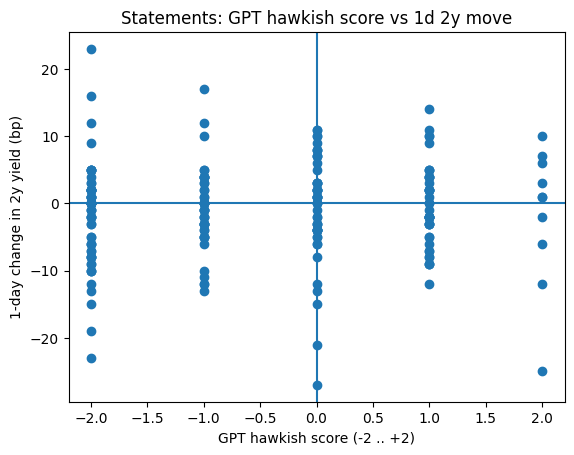

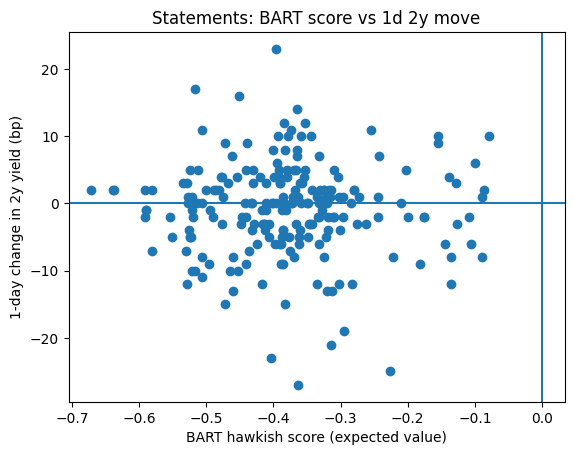

In [ ]:
plt.scatter(X_stmt["gpt_hawk_score"], X_stmt["dy2_1d_bp"])
plt.axhline(0)
plt.axvline(0)
plt.xlabel("GPT hawkish score (-2 .. +2)")
plt.ylabel("1-day change in 2y yield (bp)")
plt.title("Statements: GPT hawkish score vs 1d 2y move")
plt.show()

plt.scatter(X_stmt["bart_score"], X_stmt["dy2_1d_bp"])
plt.axhline(0)
plt.axvline(0)
plt.xlabel("BART hawkish score (expected value)")
plt.ylabel("1-day change in 2y yield (bp)")
plt.title("Statements: BART score vs 1d 2y move")
plt.show()

In [ ]:
corr_cols = [
    "finbert_score",
    "gpt_hawk_score",
    "bart_score",
    "bart_hawk_prob",
    "hawk_minus_dove",
    "delta_semantic",
    "dy2_1d_bp", "dy5_1d_bp", "dy10_1d_bp",
]
corr = X_stmt[corr_cols].corr()
print(corr)

                 finbert_score  gpt_hawk_score  bart_score  bart_hawk_prob  \
finbert_score         1.000000        0.030384   -0.065889       -0.128555   
gpt_hawk_score        0.030384        1.000000    0.468030        0.415131   
bart_score           -0.065889        0.468030    1.000000        0.833123   
bart_hawk_prob       -0.128555        0.415131    0.833123        1.000000   
hawk_minus_dove       0.041640        0.369148    0.285892        0.197805   
delta_semantic       -0.174512       -0.220086    0.078604        0.048873   
dy2_1d_bp             0.116839        0.055163   -0.018083       -0.032646   
dy5_1d_bp             0.055823        0.005887   -0.083996       -0.090483   
dy10_1d_bp            0.043456       -0.075284   -0.155578       -0.157706   

                 hawk_minus_dove  delta_semantic  dy2_1d_bp  dy5_1d_bp  \
finbert_score           0.041640       -0.174512   0.116839   0.055823   
gpt_hawk_score          0.369148       -0.220086   0.055163   0.005887 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (7, 4)

X = X_text.copy()
X_stmt = X[X["Type"] == "Statement"].copy()
print("Number of statements:", len(X_stmt))

Number of statements: 217


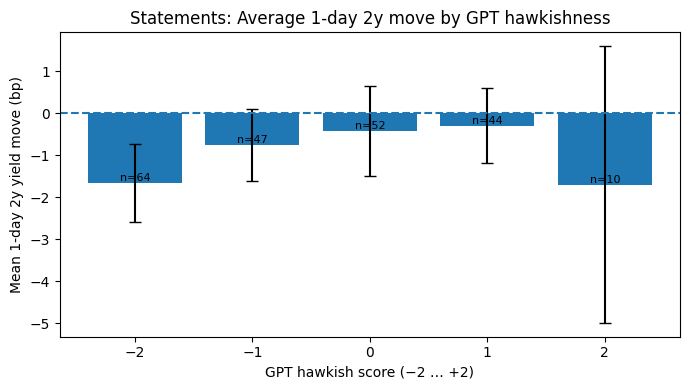

In [ ]:
group = (
    X_stmt.groupby("gpt_hawk_score")["dy2_1d_bp"]
          .agg(count="count", mean="mean", std="std")
          .reset_index()
          .sort_values("gpt_hawk_score")
)

x = group["gpt_hawk_score"].values
y = group["mean"].values
err = group["std"].values / np.sqrt(group["count"].clip(lower=1).values)

fig, ax = plt.subplots()
ax.bar(x, y, yerr=err, capsize=4)
ax.axhline(0, linestyle="--")
ax.set_xlabel("GPT hawkish score (−2 … +2)")
ax.set_ylabel("Mean 1-day 2y yield move (bp)")
ax.set_title("Statements: Average 1-day 2y move by GPT hawkishness")
for xi, yi, ci in zip(x, y, group["count"]):
    ax.text(xi, yi, f"n={ci}", ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.show()

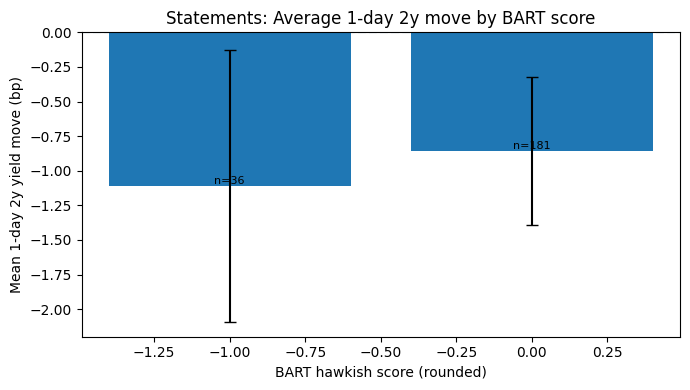

In [ ]:
X_stmt["bart_bucket"] = X_stmt["bart_score"].round()

group_b = (
    X_stmt.groupby("bart_bucket")["dy2_1d_bp"]
          .agg(count="count", mean="mean", std="std")
          .reset_index()
          .sort_values("bart_bucket")
)

x = group_b["bart_bucket"].values
y = group_b["mean"].values
err = group_b["std"].values / np.sqrt(group_b["count"].clip(lower=1).values)

fig, ax = plt.subplots()
ax.bar(x, y, yerr=err, capsize=4)
ax.axhline(0, linestyle="--")
ax.set_xlabel("BART hawkish score (rounded)")
ax.set_ylabel("Mean 1-day 2y yield move (bp)")
ax.set_title("Statements: Average 1-day 2y move by BART score")
for xi, yi, ci in zip(x, y, group_b["count"]):
    ax.text(xi, yi, f"n={ci}", ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.show()

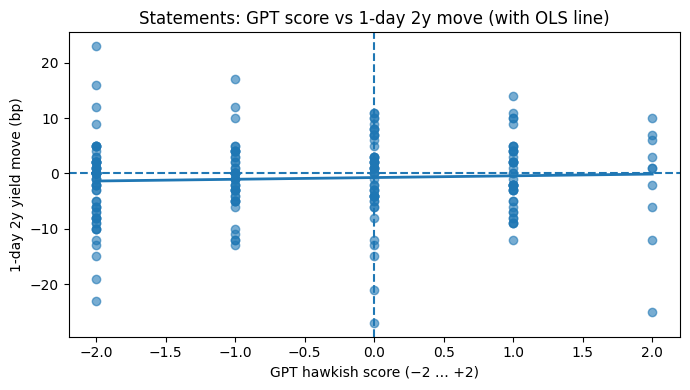

OLS slope (bp per 1 score): 0.3126796728906764


In [ ]:
from sklearn.linear_model import LinearRegression

x = X_stmt["gpt_hawk_score"].values.reshape(-1, 1)
y = X_stmt["dy2_1d_bp"].values

# Fit simple OLS
mask = ~np.isnan(x).ravel() & ~np.isnan(y)
reg = LinearRegression().fit(x[mask], y[mask])
x_line = np.linspace(-2, 2, 100).reshape(-1, 1)
y_line = reg.predict(x_line)

fig, ax = plt.subplots()
ax.scatter(X_stmt["gpt_hawk_score"], X_stmt["dy2_1d_bp"], alpha=0.6)
ax.plot(x_line.ravel(), y_line, linewidth=2)
ax.axhline(0, linestyle="--")
ax.axvline(0, linestyle="--")
ax.set_xlabel("GPT hawkish score (−2 … +2)")
ax.set_ylabel("1-day 2y yield move (bp)")
ax.set_title("Statements: GPT score vs 1-day 2y move (with OLS line)")
plt.tight_layout()
plt.show()

print("OLS slope (bp per 1 score):", reg.coef_[0])

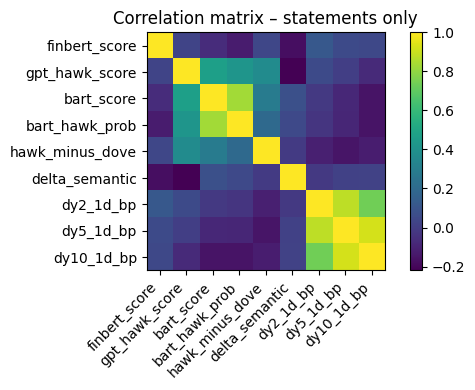

In [ ]:
corr_cols = [
    "finbert_score",
    "gpt_hawk_score",
    "bart_score",
    "bart_hawk_prob",
    "hawk_minus_dove",
    "delta_semantic",
    "dy2_1d_bp", "dy5_1d_bp", "dy10_1d_bp",
]
corr = X_stmt[corr_cols].corr()

fig, ax = plt.subplots()
im = ax.imshow(corr.values, interpolation="nearest")
ax.set_xticks(range(len(corr_cols)))
ax.set_yticks(range(len(corr_cols)))
ax.set_xticklabels(corr_cols, rotation=45, ha="right")
ax.set_yticklabels(corr_cols)
ax.set_title("Correlation matrix – statements only")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

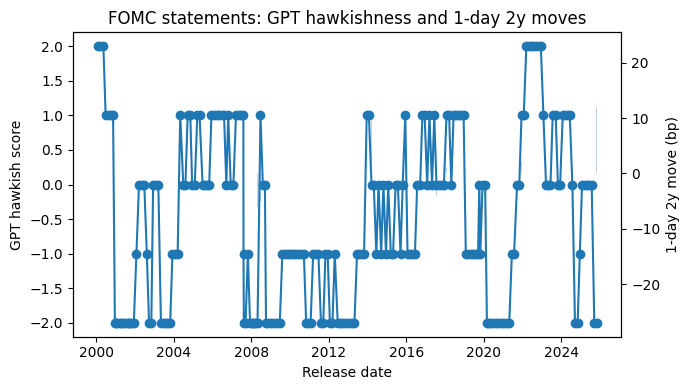

In [ ]:
X_stmt_ts = X_stmt.sort_values("Release Date").copy()
X_stmt_ts["Release Date"] = pd.to_datetime(X_stmt_ts["Release Date"])

fig, ax1 = plt.subplots()
ax1.plot(X_stmt_ts["Release Date"], X_stmt_ts["gpt_hawk_score"], marker="o")
ax1.set_xlabel("Release date")
ax1.set_ylabel("GPT hawkish score",)
ax1.set_title("FOMC statements: GPT hawkishness and 1-day 2y moves")

ax2 = ax1.twinx()
ax2.bar(X_stmt_ts["Release Date"], X_stmt_ts["dy2_1d_bp"], alpha=0.3)
ax2.set_ylabel("1-day 2y move (bp)")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Copy and ensure datetime
X = X_text.copy()
X["Release Date"] = pd.to_datetime(X["Release Date"])

# For now: use only Statements (cleanest reaction)
X_stmt = X[X["Type"] == "Statement"].copy()

# Drop rows with missing key things
X_stmt = X_stmt.dropna(subset=["dy2_1d_bp", "gpt_hawk_score"])

# Sort by time to avoid lookahead
X_stmt = X_stmt.sort_values("Release Date").reset_index(drop=True)

print("Number of statements:", len(X_stmt))

# Time-based split: train past, test future
cut_date = pd.Timestamp("2017-01-01")   # you can move this if you want
train = X_stmt[X_stmt["Release Date"] < cut_date].copy()
test  = X_stmt[X_stmt["Release Date"] >= cut_date].copy()

print("Train size:", len(train), "Test size:", len(test))

# Targets
y_train = train["dy2_1d_bp"].values     # 1-day 2y move (bp)
y_test  = test["dy2_1d_bp"].values

# Core feature sets
feat_gpt = ["gpt_hawk_score"]
feat_full = [
    "gpt_hawk_score",
    "finbert_score",
    "bart_score",
    "bart_hawk_prob",
    "hawk_minus_dove",
    "delta_semantic",
]

X1_train = train[feat_gpt].values
X1_test  = test[feat_gpt].values

Xfull_train = train[feat_full].values
Xfull_test  = test[feat_full].values

Number of statements: 217
Train size: 144 Test size: 73


In [ ]:
!pip install statsmodels

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# Add intercept
X1_train_sm = sm.add_constant(X1_train)
X1_test_sm  = sm.add_constant(X1_test)

ols_gpt = sm.OLS(y_train, X1_train_sm).fit()
print(ols_gpt.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     4.337
Date:                Fri, 14 Nov 2025   Prob (F-statistic):             0.0391
Time:                        14:49:58   Log-Likelihood:                -476.33
No. Observations:                 144   AIC:                             956.7
Df Residuals:                     142   BIC:                             962.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1991      0.650      0.306      0.7

In [ ]:
train["delta_semantic"] = train["delta_semantic"].fillna(0.0)
test["delta_semantic"]  = test["delta_semantic"].fillna(0.0)  # no NaNs but safe
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

feat_full = [
    "gpt_hawk_score",
    "finbert_score",
    "bart_score",
    "bart_hawk_prob",
    "hawk_minus_dove",
    "delta_semantic",
]

# --- make sure delta_semantic has no NaNs ---
train = train.copy()
test  = test.copy()
train["delta_semantic"] = train["delta_semantic"].fillna(0.0)
test["delta_semantic"]  = test["delta_semantic"].fillna(0.0)

# --- build a combined train DF with target + features ---
cols = feat_full + ["dy2_1d_bp"]
df_train_reg = train[cols].copy()

# replace ±inf by NaN, then drop any row with NaN
df_train_reg = df_train_reg.replace([np.inf, -np.inf], np.nan).dropna()

print("Clean train rows for regression:", len(df_train_reg))

# final X and y for regression (only from fully clean rows)
y_train = df_train_reg["dy2_1d_bp"].values
Xfull_train = df_train_reg[feat_full].values
Xfull_train_sm = sm.add_constant(Xfull_train)

Clean train rows for regression: 144


In [ ]:
y_hat_train = ols_gpt.predict(X1_train_sm)
y_hat_test  = ols_gpt.predict(X1_test_sm)

rmse_train = np.sqrt(mean_squared_error(y_train, y_hat_train))
rmse_test  = np.sqrt(mean_squared_error(y_test,  y_hat_test))

rmse_naive = np.sqrt(mean_squared_error(y_test, np.zeros_like(y_test)))

print(f"OLS (GPT only) Train RMSE (bp): {rmse_train:.3f}")
print(f"OLS (GPT only) Test  RMSE (bp): {rmse_test:.3f}")
print(f"Naive (predict 0)    Test RMSE (bp): {rmse_naive:.3f}")

OLS (GPT only) Train RMSE (bp): 6.612
OLS (GPT only) Test  RMSE (bp): 7.859
Naive (predict 0)    Test RMSE (bp): 7.639


In [ ]:
Xfull_train_sm = sm.add_constant(Xfull_train)
Xfull_test_sm  = sm.add_constant(Xfull_test)

ols_full = sm.OLS(y_train, Xfull_train_sm).fit()
print(ols_full.summary())

y_hat_train_full = ols_full.predict(Xfull_train_sm)
y_hat_test_full  = ols_full.predict(Xfull_test_sm)

rmse_train_full = np.sqrt(mean_squared_error(y_train, y_hat_train_full))
rmse_test_full  = np.sqrt(mean_squared_error(y_test,  y_hat_test_full))

print(f"OLS (full) Train RMSE (bp): {rmse_train_full:.3f}")
print(f"OLS (full) Test  RMSE (bp): {rmse_test_full:.3f}")
print(f"Naive (predict 0) Test RMSE (bp): {rmse_naive:.3f}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.259
Date:                Fri, 14 Nov 2025   Prob (F-statistic):              0.280
Time:                        15:07:26   Log-Likelihood:                -474.63
No. Observations:                 144   AIC:                             963.3
Df Residuals:                     137   BIC:                             984.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4074     10.147      0.434      0.6

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# Binary target: did 2y go up?
z_train = (y_train > 0).astype(int)
z_test  = (y_test  > 0).astype(int)

logit_gpt = LogisticRegression(max_iter=1000)
logit_gpt.fit(X1_train, z_train)

p_test_gpt = logit_gpt.predict_proba(X1_test)[:, 1]
z_pred_gpt = (p_test_gpt >= 0.5).astype(int)

acc_gpt = accuracy_score(z_test, z_pred_gpt)
auc_gpt = roc_auc_score(z_test, p_test_gpt)

# naive: always predict majority class from train
majority = int(z_train.mean() >= 0.5)
acc_naive = accuracy_score(z_test, np.full_like(z_test, majority))

print("Logit (GPT only) Test accuracy:", acc_gpt)
print("Logit (GPT only) Test AUC:", auc_gpt)
print("Naive (always {}) accuracy: {}".format(majority, acc_naive))

Logit (GPT only) Test accuracy: 0.5205479452054794
Logit (GPT only) Test AUC: 0.5213178294573644
Naive (always 0) accuracy: 0.589041095890411


In [ ]:
logit_full = LogisticRegression(max_iter=1000)
logit_full.fit(Xfull_train, z_train)

p_test_full = logit_full.predict_proba(Xfull_test)[:, 1]
z_pred_full = (p_test_full >= 0.5).astype(int)

acc_full = accuracy_score(z_test, z_pred_full)
auc_full = roc_auc_score(z_test, p_test_full)

print("Logit (full) Test accuracy:", acc_full)
print("Logit (full) Test AUC:", auc_full)
print("Naive (always {}) accuracy: {}".format(majority, acc_naive))

Logit (full) Test accuracy: 0.5205479452054794
Logit (full) Test AUC: 0.5224806201550387
Naive (always 0) accuracy: 0.589041095890411


In [ ]:
feat_full = [
    "gpt_hawk_score",
    "finbert_score",
    "bart_score",
    "bart_hawk_prob",
    "hawk_minus_dove",
    "delta_semantic",
]

print("Missing in train:")
print(train[feat_full].isna().sum())

print("\nMissing in test:")
print(test[feat_full].isna().sum())

Missing in train:
gpt_hawk_score     0
finbert_score      0
bart_score         0
bart_hawk_prob     0
hawk_minus_dove    0
delta_semantic     0
dtype: int64

Missing in test:
gpt_hawk_score     0
finbert_score      0
bart_score         0
bart_hawk_prob     0
hawk_minus_dove    0
delta_semantic     0
dtype: int64


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ---------- Regression: clean train/test for both models ----------

feat_gpt = ["gpt_hawk_score"]
feat_full = [
    "gpt_hawk_score",
    "finbert_score",
    "bart_score",
    "bart_hawk_prob",
    "hawk_minus_dove",
    "delta_semantic",
]

# Ensure delta_semantic has no NaNs
train = train.copy()
test  = test.copy()
train["delta_semantic"] = train["delta_semantic"].fillna(0.0)
test["delta_semantic"]  = test["delta_semantic"].fillna(0.0)

# Build clean train/test DF for regression
cols_full = feat_full + ["dy2_1d_bp"]
df_train_reg = train[cols_full].replace([np.inf, -np.inf], np.nan).dropna()
df_test_reg  = test[cols_full].replace([np.inf, -np.inf], np.nan).dropna()

print("Clean train rows:", len(df_train_reg), "Clean test rows:", len(df_test_reg))

y_train = df_train_reg["dy2_1d_bp"].values
y_test  = df_test_reg["dy2_1d_bp"].values

# GPT-only design matrices
X1_train = df_train_reg[feat_gpt].values
X1_test  = df_test_reg[feat_gpt].values
X1_train_sm = sm.add_constant(X1_train)
X1_test_sm  = sm.add_constant(X1_test)

# Full-feature design matrices
Xfull_train = df_train_reg[feat_full].values
Xfull_test  = df_test_reg[feat_full].values
Xfull_train_sm = sm.add_constant(Xfull_train)
Xfull_test_sm  = sm.add_constant(Xfull_test)

# Fit OLS models
ols_gpt  = sm.OLS(y_train, X1_train_sm).fit()
ols_full = sm.OLS(y_train, Xfull_train_sm).fit()

print(ols_gpt.summary())
print(ols_full.summary())

# Predictions
y_hat_train_gpt  = ols_gpt.predict(X1_train_sm)
y_hat_test_gpt   = ols_gpt.predict(X1_test_sm)
y_hat_train_full = ols_full.predict(Xfull_train_sm)
y_hat_test_full  = ols_full.predict(Xfull_test_sm)

rmse_naive = np.sqrt(mean_squared_error(y_test, np.zeros_like(y_test)))

print("\nRMSE (bp):")
print("  GPT-only   Train:", np.sqrt(mean_squared_error(y_train, y_hat_train_gpt)),
      "Test:", np.sqrt(mean_squared_error(y_test, y_hat_test_gpt)))
print("  Full       Train:", np.sqrt(mean_squared_error(y_train, y_hat_train_full)),
      "Test:", np.sqrt(mean_squared_error(y_test, y_hat_test_full)))
print("  Naive (0)  Test:", rmse_naive)

Clean train rows: 144 Clean test rows: 73
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     4.337
Date:                Fri, 14 Nov 2025   Prob (F-statistic):             0.0391
Time:                        15:12:59   Log-Likelihood:                -476.33
No. Observations:                 144   AIC:                             956.7
Df Residuals:                     142   BIC:                             962.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

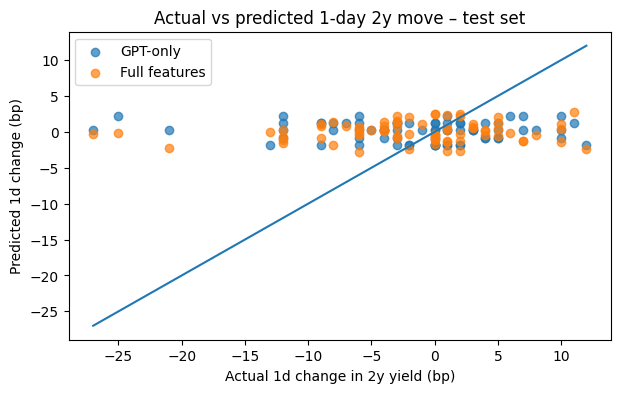

In [ ]:
# ---------- Scatter: actual vs predicted on test ----------

fig, ax = plt.subplots()

ax.scatter(y_test, y_hat_test_gpt, alpha=0.7, label="GPT-only")
ax.scatter(y_test, y_hat_test_full, alpha=0.7, label="Full features")

lims = [
    min(y_test.min(), y_hat_test_gpt.min(), y_hat_test_full.min()),
    max(y_test.max(), y_hat_test_gpt.max(), y_hat_test_full.max()),
]
ax.plot(lims, lims)  # 45-degree line

ax.set_xlabel("Actual 1d change in 2y yield (bp)")
ax.set_ylabel("Predicted 1d change (bp)")
ax.set_title("Actual vs predicted 1-day 2y move – test set")
ax.legend()
plt.show()


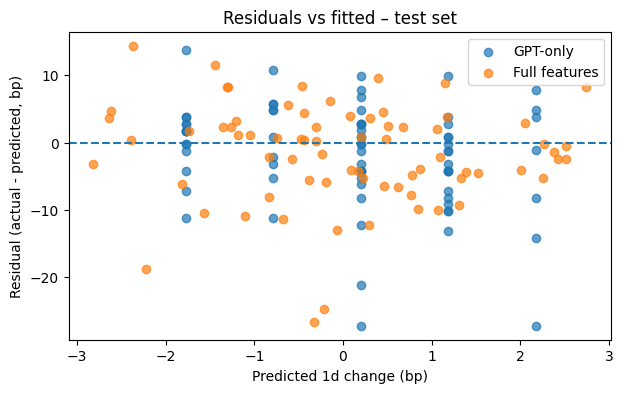

In [ ]:
# ---------- Residuals vs predicted (test) ----------

res_test_gpt  = y_test - y_hat_test_gpt
res_test_full = y_test - y_hat_test_full

fig, ax = plt.subplots()

ax.scatter(y_hat_test_gpt,  res_test_gpt,  alpha=0.7, label="GPT-only")
ax.scatter(y_hat_test_full, res_test_full, alpha=0.7, label="Full features")

ax.axhline(0, linestyle="--")
ax.set_xlabel("Predicted 1d change (bp)")
ax.set_ylabel("Residual (actual - predicted, bp)")
ax.set_title("Residuals vs fitted – test set")
ax.legend()
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# Binary targets
z_train = (y_train > 0).astype(int)
z_test  = (y_test  > 0).astype(int)

# GPT-only logistic
logit_gpt = LogisticRegression(max_iter=1000)
logit_gpt.fit(X1_train, z_train)

p_test_gpt = logit_gpt.predict_proba(X1_test)[:, 1]
z_pred_gpt = (p_test_gpt >= 0.5).astype(int)

# Full logistic
logit_full = LogisticRegression(max_iter=1000)
logit_full.fit(Xfull_train, z_train)

p_test_full = logit_full.predict_proba(Xfull_test)[:, 1]
z_pred_full = (p_test_full >= 0.5).astype(int)



acc_gpt   = accuracy_score(z_test, z_pred_gpt)
acc_full  = accuracy_score(z_test, z_pred_full)


auc_gpt  = roc_auc_score(z_test, p_test_gpt)
auc_full = roc_auc_score(z_test, p_test_full)

print("Accuracy:")
print("  GPT-only:   ", acc_gpt)
print("  Full:       ", acc_full)

print("\nAUC:")
print("  GPT-only:   ", auc_gpt)
print("  Full:       ", auc_full)

Accuracy:
  GPT-only:    0.5205479452054794
  Full:        0.5205479452054794

AUC:
  GPT-only:    0.5213178294573644
  Full:        0.5224806201550387


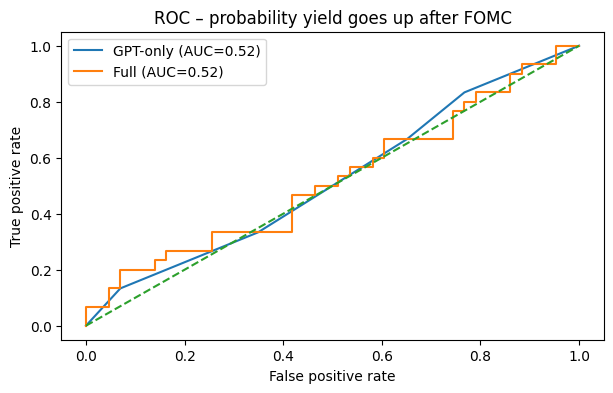

In [ ]:
# ---------- ROC curves ----------

fpr_gpt,  tpr_gpt,  _ = roc_curve(z_test, p_test_gpt)
fpr_full, tpr_full, _ = roc_curve(z_test, p_test_full)

fig, ax = plt.subplots()

ax.plot(fpr_gpt,  tpr_gpt,  label=f"GPT-only (AUC={auc_gpt:.2f})")
ax.plot(fpr_full, tpr_full, label=f"Full (AUC={auc_full:.2f})")
ax.plot([0,1], [0,1], linestyle="--")

ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("ROC – probability yield goes up after FOMC")
ax.legend()
plt.show()

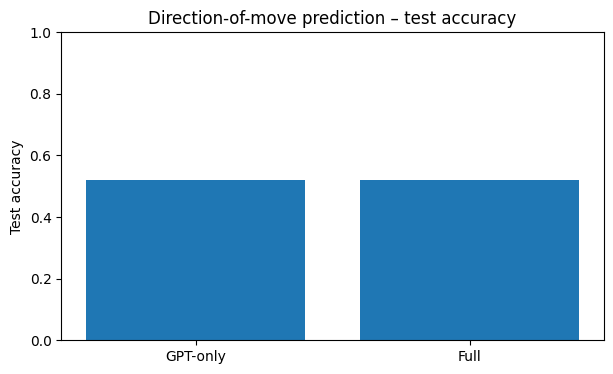

In [ ]:
# ---------- Bar chart of accuracy ----------

methods = [ "GPT-only", "Full"]
accs    = [ acc_gpt, acc_full]

fig, ax = plt.subplots()
ax.bar(methods, accs)
ax.set_ylim(0, 1)
ax.set_ylabel("Test accuracy")
ax.set_title("Direction-of-move prediction – test accuracy")
plt.show()

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score

# ---- features we use ----
feat_full = [
    "gpt_hawk_score",
    "finbert_score",
    "bart_score",
    "bart_hawk_prob",
    "hawk_minus_dove",
    "delta_semantic",
]

# ensure no NaNs in delta_semantic
train_nn = train.copy()
test_nn  = test.copy()
train_nn["delta_semantic"] = train_nn["delta_semantic"].fillna(0.0)
test_nn["delta_semantic"]  = test_nn["delta_semantic"].fillna(0.0)

# build regression DFs and drop any remaining NaN/inf
cols = feat_full + ["dy2_1d_bp"]
df_train_reg = train_nn[cols].replace([np.inf, -np.inf], np.nan).dropna()
df_test_reg  = test_nn[cols].replace([np.inf, -np.inf], np.nan).dropna()

print("NN clean train rows:", len(df_train_reg), "NN clean test rows:", len(df_test_reg))

X_train_nn = df_train_reg[feat_full].values
X_test_nn  = df_test_reg[feat_full].values

y_train_nn = df_train_reg["dy2_1d_bp"].values
y_test_nn  = df_test_reg["dy2_1d_bp"].values

# classification target: direction of move
z_train_nn = (y_train_nn > 0).astype(int)
z_test_nn  = (y_test_nn  > 0).astype(int)

# naive baseline (same as before)
rmse_naive_nn = np.sqrt(mean_squared_error(y_test_nn, np.zeros_like(y_test_nn)))
maj = int(z_train_nn.mean() >= 0.5)
acc_naive_nn = accuracy_score(z_test_nn, np.full_like(z_test_nn, maj))

print("Naive regression RMSE (bp):", rmse_naive_nn)
print("Naive classification accuracy:", acc_naive_nn)

NN clean train rows: 144 NN clean test rows: 73
Naive regression RMSE (bp): 7.639120655125277
Naive classification accuracy: 0.589041095890411


In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(16,),
        activation="relu",
        alpha=1e-3,
        learning_rate_init=1e-3,
        max_iter=5000,
        early_stopping=True,
        n_iter_no_change=25,
        random_state=0
    ))
])

mlp_clf.fit(X_train_nn, z_train_nn)

p_test_mlp = mlp_clf.predict_proba(X_test_nn)[:, 1]
z_pred_mlp = (p_test_mlp >= 0.5).astype(int)

acc_mlp = accuracy_score(z_test_nn, z_pred_mlp)
auc_mlp = roc_auc_score(z_test_nn, p_test_mlp)

print("MLP classification:")
print("  Test accuracy:", acc_mlp)
print("  Test AUC     :", auc_mlp)
print("  Naive acc    :", acc_naive_nn)

MLP classification:
  Test accuracy: 0.410958904109589
  Test AUC     : 0.437984496124031
  Naive acc    : 0.589041095890411


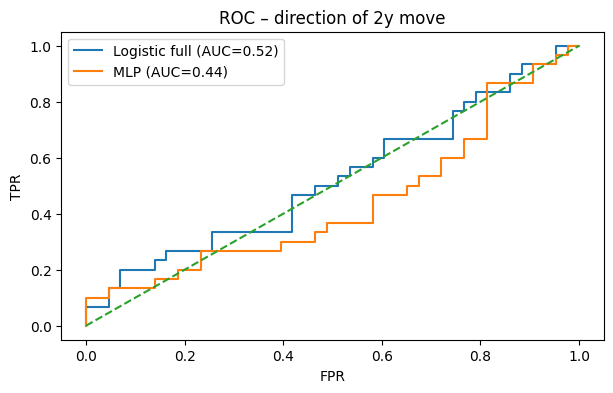

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# assuming you still have p_test_full from logistic
fpr_log, tpr_log, _ = roc_curve(z_test_nn, p_test_full)  # full logistic
fpr_mlp, tpr_mlp, _ = roc_curve(z_test_nn, p_test_mlp)

fig, ax = plt.subplots()
ax.plot(fpr_log, tpr_log, label=f"Logistic full (AUC={auc_full:.2f})")
ax.plot(fpr_mlp, tpr_mlp, label=f"MLP (AUC={auc_mlp:.2f})")
ax.plot([0,1], [0,1], "--")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("ROC – direction of 2y move")
ax.legend()
plt.show()

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error

hgb_reg = HistGradientBoostingRegressor(
    max_depth=3,        # keep trees shallow to avoid overfit
    learning_rate=0.05,
    max_iter=200,
    min_samples_leaf=10,
    random_state=0
)

hgb_reg.fit(X_train_nn, y_train_nn)

y_hat_train_hgb = hgb_reg.predict(X_train_nn)
y_hat_test_hgb  = hgb_reg.predict(X_test_nn)

rmse_train_hgb = np.sqrt(mean_squared_error(y_train_nn, y_hat_train_hgb))
rmse_test_hgb  = np.sqrt(mean_squared_error(y_test_nn,  y_hat_test_hgb))

print("HistGB Regression RMSE (bp):")
print("  Train:", rmse_train_hgb)
print("  Test :", rmse_test_hgb)
print("  Naive:", rmse_naive_nn)

HistGB Regression RMSE (bp):
  Train: 3.910261398478651
  Test : 8.131582436336302
  Naive: 7.639120655125277


In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

hgb_clf = HistGradientBoostingClassifier(
    max_depth=3,
    learning_rate=0.05,
    max_iter=200,
    min_samples_leaf=10,
    random_state=0
)

hgb_clf.fit(X_train_nn, z_train_nn)

p_test_hgb = hgb_clf.predict_proba(X_test_nn)[:, 1]
z_pred_hgb = (p_test_hgb >= 0.5).astype(int)

acc_hgb = accuracy_score(z_test_nn, z_pred_hgb)
auc_hgb = roc_auc_score(z_test_nn, p_test_hgb)

print("HistGB Classification:")
print("  Test accuracy:", acc_hgb)
print("  Test AUC     :", auc_hgb)
print("  Naive acc    :", acc_naive_nn)

HistGB Classification:
  Test accuracy: 0.5205479452054794
  Test AUC     : 0.5317829457364341
  Naive acc    : 0.589041095890411


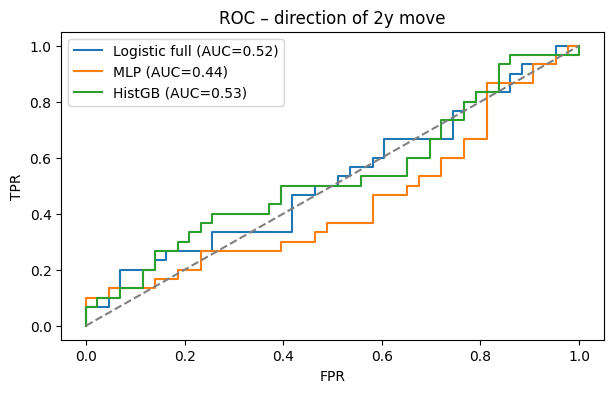

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# assuming p_test_full (logistic) and p_test_mlp (MLP) still defined
fpr_log, tpr_log, _ = roc_curve(z_test_nn, p_test_full)
fpr_mlp, tpr_mlp, _ = roc_curve(z_test_nn, p_test_mlp)
fpr_hgb, tpr_hgb, _ = roc_curve(z_test_nn, p_test_hgb)

fig, ax = plt.subplots()
ax.plot(fpr_log, tpr_log, label=f"Logistic full (AUC={auc_gpt:.2f})")
ax.plot(fpr_mlp, tpr_mlp, label=f"MLP (AUC={auc_mlp:.2f})")
ax.plot(fpr_hgb, tpr_hgb, label=f"HistGB (AUC={auc_hgb:.2f})")
ax.plot([0,1], [0,1], "--", color="grey")

ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("ROC – direction of 2y move")
ax.legend()
plt.show()

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_nn, y_train_nn)
y_hat_test_ridge = ridge.predict(X_test_nn)
rmse_test_ridge = np.sqrt(mean_squared_error(y_test_nn, y_hat_test_ridge))

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(
    n_estimators=300,
    max_depth=4,
    min_samples_leaf=10,
    random_state=0
)
rf_reg.fit(X_train_nn, y_train_nn)
y_hat_test_rf = rf_reg.predict(X_test_nn)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=4,
    min_samples_leaf=10,
    random_state=0
)
rf_clf.fit(X_train_nn, z_train_nn)
p_test_rf = rf_clf.predict_proba(X_test_nn)[:,1]
auc_rf = roc_auc_score(z_test_nn, p_test_rf)
acc_rf = accuracy_score(z_test_nn, (p_test_rf>=0.5).astype(int))

In [ ]:
thr = 5.0  # bp
mask = np.abs(y_train_nn) >= thr
# train only on big moves
X_train_big = X_train_nn[mask]
z_train_big = (y_train_nn[mask] > 0).astype(int)

mask_test = np.abs(y_test_nn) >= thr
X_test_big = X_test_nn[mask_test]
z_test_big = (y_test_nn[mask_test] > 0).astype(int)

In [ ]:
df_fe = X.copy()

# Agreement / disagreement between models
df_fe["gpt_sign"]      = np.sign(df_fe["gpt_hawk_score"])
df_fe["finbert_sign"]  = np.sign(df_fe["finbert_score"])
df_fe["bart_sign"]     = np.sign(df_fe["bart_score"])

df_fe["agree_all"] = ((df_fe["gpt_sign"] == df_fe["finbert_sign"]) &
                      (df_fe["gpt_sign"] == df_fe["bart_sign"])).astype(int)

# Magnitude: "how strong is the consensus"
df_fe["avg_score"]  = (df_fe["gpt_hawk_score"] +
                       df_fe["finbert_score"] +
                       df_fe["bart_score"]) / 3.0
df_fe["abs_avg_score"] = df_fe["avg_score"].abs()

# Non-linear terms
df_fe["gpt_sq"]    = df_fe["gpt_hawk_score"]**2
df_fe["delta_sq"]  = df_fe["delta_semantic"]**2
df_fe["gpt_x_delta"] = df_fe["gpt_hawk_score"] * df_fe["delta_semantic"]

# Type dummy: Statement vs Minute
df_fe["is_minute"] = (df_fe["Type"] == "Minute").astype(int)
df_fe["gpt_x_minute"] = df_fe["gpt_hawk_score"] * df_fe["is_minute"]

In [ ]:
feat_rich = [
    "gpt_hawk_score",
    "finbert_score",
    "bart_score",
    "bart_hawk_prob",
    "hawk_minus_dove",
    "delta_semantic",
    "abs_avg_score",
    "agree_all",
    "gpt_sq",
    "delta_sq",
    "gpt_x_delta",
    "is_minute",
    "gpt_x_minute",
]

In [ ]:
df = X_text.copy()
df["Release Date"] = pd.to_datetime(df["Release Date"])
df["delta_semantic"] = df["delta_semantic"].fillna(0.0)

# ---- basic signs ----
df["gpt_sign"]     = np.sign(df["gpt_hawk_score"])
df["finbert_sign"] = np.sign(df["finbert_score"])
df["bart_sign"]    = np.sign(df["bart_score"])

# all three agree on sign?
df["agree_all"] = (
    (df["gpt_sign"] == df["finbert_sign"]) &
    (df["gpt_sign"] == df["bart_sign"])
).astype(int)

# average and magnitude of hawkishness
df["avg_score"]      = (df["gpt_hawk_score"] + df["finbert_score"] + df["bart_score"]) / 3.0
df["abs_avg_score"]  = df["avg_score"].abs()

# non-linearities / interactions
df["gpt_sq"]        = df["gpt_hawk_score"]**2
df["delta_sq"]      = df["delta_semantic"]**2
df["gpt_x_delta"]   = df["gpt_hawk_score"] * df["delta_semantic"]

# type dummy
df["is_minute"]     = (df["Type"] == "Minute").astype(int)
df["gpt_x_minute"]  = df["gpt_hawk_score"] * df["is_minute"]

In [ ]:
feat_rich = [
    "gpt_hawk_score",
    "finbert_score",
    "bart_score",
    "bart_hawk_prob",
    "hawk_minus_dove",
    "delta_semantic",
    "abs_avg_score",
    "agree_all",
    "gpt_sq",
    "delta_sq",
    "gpt_x_delta",
    "is_minute",
    "gpt_x_minute",
]

In [ ]:
# keep events where we have target + GPT
df_ev = df[df["Type"].isin(["Statement", "Minute"])].copy()
df_ev = df_ev.dropna(subset=["dy2_1d_bp", "gpt_hawk_score"])

df_ev = df_ev.sort_values("Release Date").reset_index(drop=True)

cut_date = pd.Timestamp("2017-01-01")
train = df_ev[df_ev["Release Date"] < cut_date].copy()
test  = df_ev[df_ev["Release Date"] >= cut_date].copy()

# clean / finite
cols = feat_rich + ["dy2_1d_bp"]
train = train[cols].replace([np.inf, -np.inf], np.nan).dropna()
test  = test[cols].replace([np.inf, -np.inf], np.nan).dropna()

X_train = train[feat_rich].values
X_test  = test[feat_rich].values

y_train = train["dy2_1d_bp"].values
y_test  = test["dy2_1d_bp"].values

# classification: sign and "big move"
z_train = (y_train > 0).astype(int)
z_test  = (y_test  > 0).astype(int)

thr = 5.0  # bp threshold for a "large" move
mask_tr = np.abs(y_train) >= thr
mask_te = np.abs(y_test)  >= thr

X_train_big = X_train[mask_tr]
X_test_big  = X_test[mask_te]
z_train_big = z_train[mask_tr]
z_test_big  = z_test[mask_te]

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# naive baseline
rmse_naive = np.sqrt(mean_squared_error(y_test, np.zeros_like(y_test)))

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_hat_test_ridge = ridge.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_hat_test_ridge))

hgb_reg = HistGradientBoostingRegressor(
    max_depth=3,
    learning_rate=0.05,
    max_iter=200,
    min_samples_leaf=10,
    random_state=0
)
hgb_reg.fit(X_train, y_train)
y_hat_test_hgb = hgb_reg.predict(X_test)
rmse_hgb = np.sqrt(mean_squared_error(y_test, y_hat_test_hgb))

print("RMSE test (bp):")
print("  Naive  :", rmse_naive)
print("  Ridge  :", rmse_ridge)
print("  HistGB :", rmse_hgb)

RMSE test (bp):
  Naive  : 7.639120655125277
  Ridge  : 7.760209452362411
  HistGB : 7.976237935287715


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# majority baseline on big moves
maj = int(z_train_big.mean() >= 0.5)
acc_naive_big = accuracy_score(z_test_big, np.full_like(z_test_big, maj))

log_big = LogisticRegression(max_iter=1000)
log_big.fit(X_train_big, z_train_big)
p_big_log = log_big.predict_proba(X_test_big)[:,1]
auc_big_log = roc_auc_score(z_test_big, p_big_log)
acc_big_log = accuracy_score(z_test_big, (p_big_log>=0.5).astype(int))

hgb_big = HistGradientBoostingClassifier(
    max_depth=3,
    learning_rate=0.05,
    max_iter=200,
    min_samples_leaf=10,
    random_state=0
)
hgb_big.fit(X_train_big, z_train_big)
p_big_hgb = hgb_big.predict_proba(X_test_big)[:,1]
auc_big_hgb = roc_auc_score(z_test_big, p_big_hgb)
acc_big_hgb = accuracy_score(z_test_big, (p_big_hgb>=0.5).astype(int))

print("Big-move classification (|Δy| ≥ 5bp):")
print("  Naive acc :", acc_naive_big)
print("  Logit acc :", acc_big_log, "AUC:", auc_big_log)
print("  HistGB acc:", acc_big_hgb, "AUC:", auc_big_hgb)

Big-move classification (|Δy| ≥ 5bp):
  Naive acc : 0.6333333333333333
  Logit acc : 0.4 AUC: 0.46411483253588515
  HistGB acc: 0.4666666666666667 AUC: 0.5526315789473684


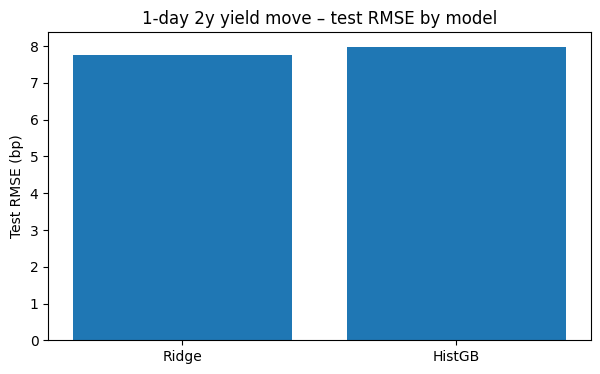

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


rmse_ridge = np.sqrt(mean_squared_error(y_test, y_hat_test_ridge))
rmse_hgb   = np.sqrt(mean_squared_error(y_test, y_hat_test_hgb))


models_reg   = [ "Ridge", "HistGB", ]
rmse_values  = [ rmse_ridge, rmse_hgb]

fig, ax = plt.subplots()
ax.bar(models_reg, rmse_values)
ax.set_ylabel("Test RMSE (bp)")
ax.set_title("1-day 2y yield move – test RMSE by model")
plt.show()